## Attribute Relationships and Visualization

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

df_v = pd.read_csv("NY_Listings_Validated.csv")
df_v = df_v.drop(df_v.columns[0], axis = 1)

### Correlation

First, in order to reduce the number of continuous variables a correlation matrix will be generated.
From this we can omit anything that has a correlation of 0.5 or greater. Typically this is the cutoff for variables that are highly correlated

In [104]:
corr = df_v.corr()
c1 = corr.abs().unstack()

c1.sort_values(ascending=True, inplace=True)
columns_above_50 = [(col1, col2) for col1, col2 in c1.index if c1[col1,col2] > 0.5 and col1 != col2]
columns_above_50

[('longitude', 'latitude'),
 ('latitude', 'longitude'),
 ('Price', 'Accommodates'),
 ('Accommodates', 'Price'),
 ('Number of reviews', 'Reviews per month'),
 ('Reviews per month', 'Number of reviews'),
 ('Bedrooms', 'Accommodates'),
 ('Accommodates', 'Bedrooms'),
 ('Review Scores Location', 'Review Scores Cleanliness'),
 ('Review Scores Cleanliness', 'Review Scores Location'),
 ('Review Scores Checkin', 'Review Scores Cleanliness'),
 ('Review Scores Cleanliness', 'Review Scores Checkin'),
 ('Review Scores Location', 'Review Scores Rating'),
 ('Review Scores Rating', 'Review Scores Location'),
 ('Review Scores Value', 'Review Scores Cleanliness'),
 ('Review Scores Cleanliness', 'Review Scores Value'),
 ('Review Scores Location', 'Review Scores Accuracy'),
 ('Review Scores Accuracy', 'Review Scores Location'),
 ('Review Scores Communication', 'Review Scores Cleanliness'),
 ('Review Scores Cleanliness', 'Review Scores Communication'),
 ('Review Scores Communication', 'Review Scores Locati

### Removing Highly Correlated or Non Useable Columns

Not surprisingly all of the variables that deal with ratings are highly correlated. Airbnb has a number of different ratings that it uses to classify a rental. These include things like cleanliness, checkin, communication, etc...
Since we are only concerned with <b>Review Scores Rating</b>, and any other review score would be a derivitave of this score, we will remove any column containing 'Review Scores...' and only retain <b>Review Scores Rating</b>.

<b>latitude</b> and <b>longitude</b> together describe a single point so they would be highly correlated. Since we have another location variable, <b>City</b>, we can omit these since they provide redundant information.

<b>Price</b> and <b>Accommodates</b> are highly correlated and so are <b>Accommodates</b> and <b>Bedrooms</b>. In order to simplify the variables we will omit <b>Accomodates</b>.

Lastly from the correlation matrix we can see that <b>Reviews per month</b> and <b>Number of Reviews</b> are highly correlated. Since <b>Number of Reviews</b> contains more information we will retain it and remove <b>Reviews per month</b>.

A couple of other columns will be removed in this step, but not based off of the results of the correlation matrix. <b>Country</b> and <b>State</b> contain only one value, and <b>Street</b> contains incorrect information. Also, <b>Amenities</b> will be removed due to its textual complexity.

> code taken from https://stackoverflow.com/questions/61329582/printing-columns-with-a-correlation-greater-than-80

In [64]:
omit = ['Review Scores Location', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Accuracy', 'Review Scores Value', 'longitude', 'latitude', 'Accommodates', 'Country', 'State', 'Street', 'Amenities', 'Reviews per month']

dfOmit = df_v.drop(omit, axis=1)

Now that our correlated variables have been removed we are left with a dataframe that looks like the following.

In [65]:
dfOmit.head()

,Listing ID,Host ID,Host Response Rate,Host Is Superhost,Host total listings count,City,Neighbourhood cleansed,Property type,Room type,Bathrooms,Bedrooms,Price,Minimum nights,Maximum nights,Availability 365,Number of reviews,Review Scores Rating
0,2515,16286162,1.0,False,4.0,Bronx,Allerton,House,Private room,1.0,1.0,43,2,30.0,276,66,96
1,2539,44260966,1.0,False,1.0,Bronx,Soundview,House,Private room,1.0,1.0,28,2,31.0,345,38,89
2,2595,105394139,1.0,False,16.0,Bronx,Fordham,House,Private room,3.0,2.0,80,3,31.0,355,18,90
3,3330,104262517,0.7,False,1.0,Bronx,Fordham,Apartment,Entire home/apt,1.0,1.0,140,2,1125.0,358,7,85
4,3647,58126473,1.0,False,1.0,Bronx,Fordham,Apartment,Private room,1.0,1.0,60,1,1125.0,360,56,95


Now that we have simplified the continous variables we can use PairGrid from seaborn for a quick visualization.

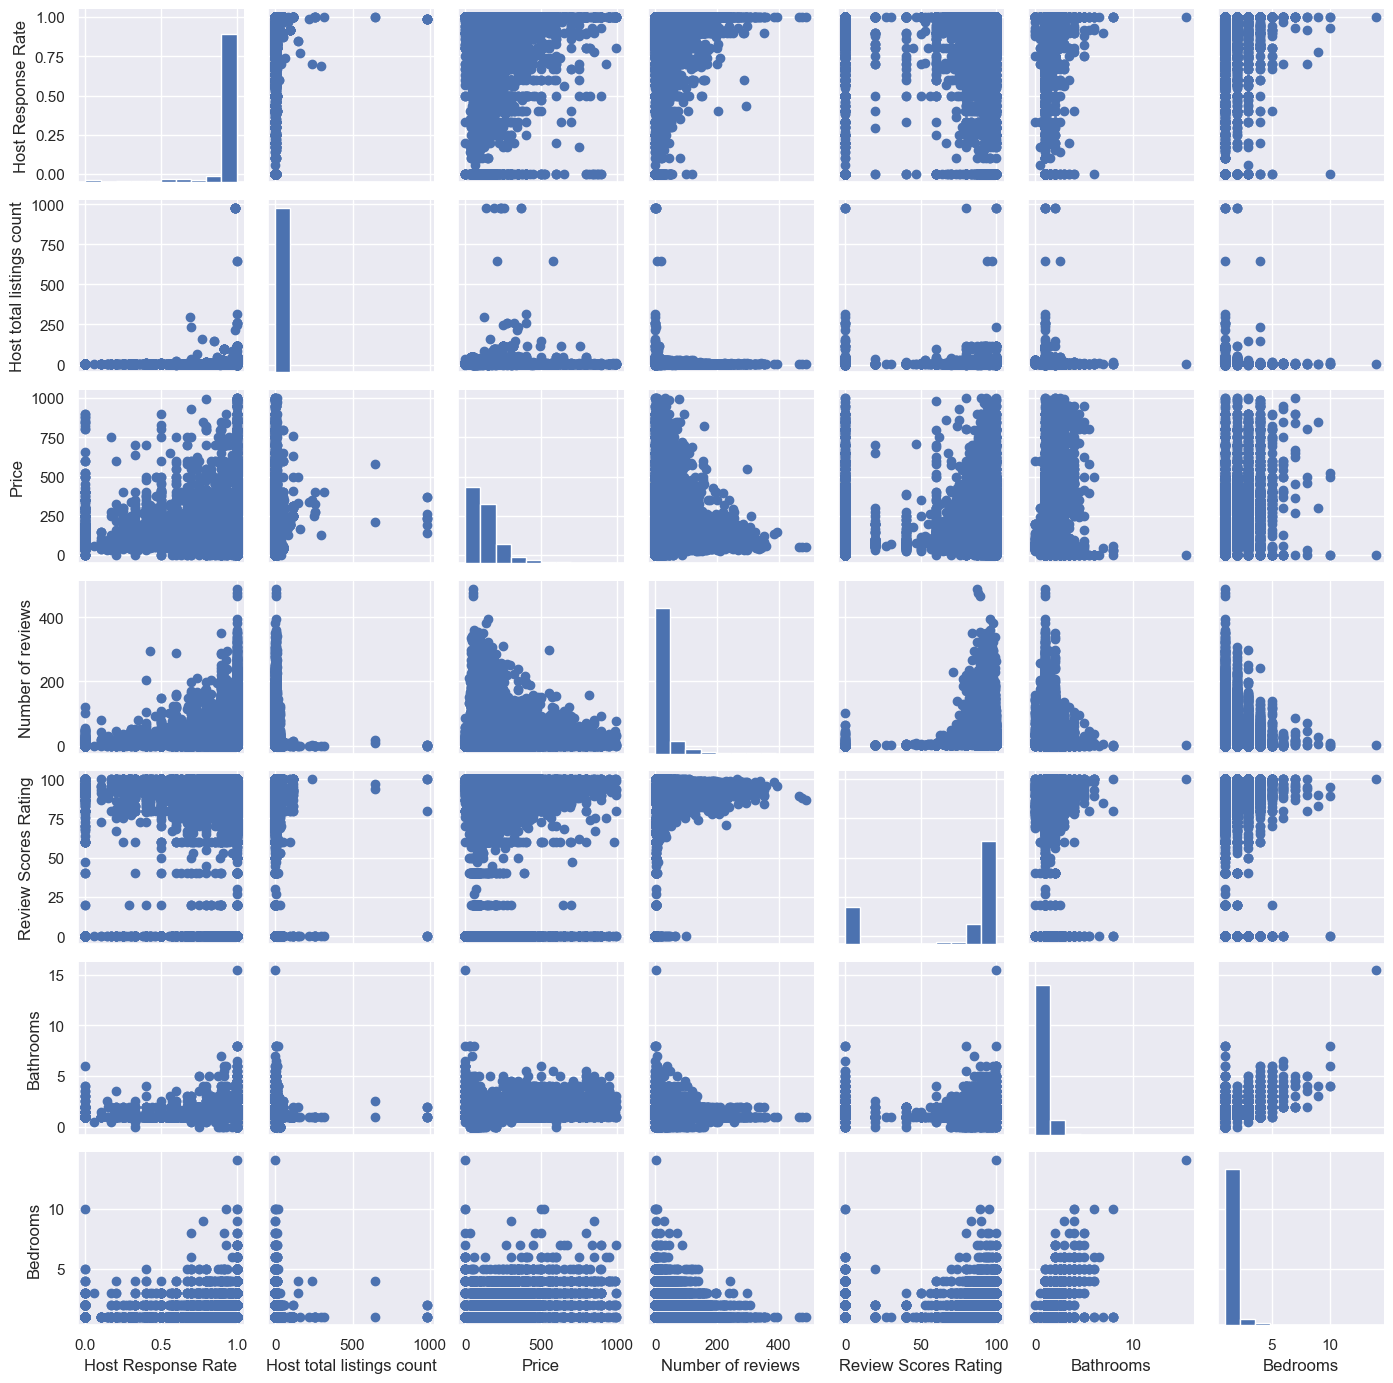

In [101]:
continuous = ['Host Response Rate', 'Host total listings count', 'Price', 'Number of reviews', 'Review Scores Rating', 'Bathrooms', 'Bedrooms']
categorical = ['Host Is Superhost', 'City', 'Neighbourhood cleansed', 'Property type', 'Room type']


graph = sns.PairGrid(dfOmit[continuous])
graph = graph.map_diag(plt.hist)
graph = graph.map_offdiag(plt.scatter)
graph.fig.set_size_inches(14,14)

Very few relationships can be seen from the PairGrid graph concerning <b>Review Scores Rating</b> and any other variable. The only strong linear relationship shown is between <b>Bedrooms</b> and <b>Bathrooms</b>. It may be best to avoid using these two variables together when making predictions.

We will have to look to other methods and the continous variables in order to identify relationships.

### Attributes That Contribute to Review Scores

In [77]:
from IPython.display import display, HTML

pd.options.display.max_rows = 300
# Puts the scrollbar next to the DataFrame
display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" +
             dfOmit.groupby(['Neighbourhood cleansed']).mean().sort_values(by='Review Scores Rating', ascending=False).to_html() +
             "</div>"))


#dfOmit.groupby(['Neighbourhood cleansed']).mean().sort_values(by='Review Scores Rating', ascending=False)

,Listing ID,Host ID,Host Response Rate,Host Is Superhost,Host total listings count,Bathrooms,Bedrooms,Price,Minimum nights,Maximum nights,Availability 365,Number of reviews,Review Scores Rating
Neighbourhood cleansed,,,,,,,,,,,,,
Oakwood,2.112210e+07,1.035459e+08,1.000000,0.000000,1.000000,1.000000,1.000000,100.000000,2.000000,3.650000e+02,0.000000,2.000000,100.000000
Grant City,2.117636e+07,5.949541e+06,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,3.000000,2.700000e+01,107.000000,18.000000,99.000000
Grymes Hill,2.114275e+07,4.456949e+07,0.903333,0.333333,1.666667,1.000000,1.000000,100.666667,2.000000,7.546667e+02,234.333333,12.000000,98.666667
Neponsit,2.062162e+07,6.260866e+07,1.000000,0.000000,1.000000,1.000000,1.000000,137.000000,2.000000,1.125000e+03,162.000000,10.000000,98.000000
Hollis Hills,2.089442e+07,6.642495e+07,1.000000,0.500000,1.000000,1.500000,2.000000,267.500000,2.000000,1.350000e+01,265.000000,32.000000,98.000000
Huguenot,2.112934e+07,8.200152e+07,1.000000,0.500000,1.500000,1.000000,1.000000,90.500000,1.000000,2.650000e+01,240.000000,28.500000,98.000000
Castleton Corners,2.114275e+07,3.826499e+07,1.000000,0.400000,2.200000,1.000000,2.200000,140.600000,2.000000,2.424000e+02,258.000000,11.200000,97.800000
Arden Heights,2.112304e+07,3.211378e+07,1.000000,0.000000,4.000000,1.000000,1.000000,37.750000,1.000000,5.925000e+02,245.750000,42.500000,97.500000
Unionport,4.740011e+06,6.442568e+07,0.750000,0.250000,1.000000,1.375000,2.250000,103.750000,2.750000,8.512500e+02,234.500000,12.750000,97.000000


When grouped by Neighbourhood we can see that the average <b>Review Scores Rating</b> has a wide spread and is clearly affected by which Neighborhoud the listing was located in.

As mentioned in the "Business Understanding" section one of the goals is to classify based on whether or not a listing has a rating above 60. In order to generate graphs we will create a column that encodes the ratings variable.

In [68]:
def review_ternary(review):
    if review >= 60:
        return '> 60'
    elif review > 0:
        return '< 60'
    else:
        return 'No Review Given'

dfOmit['Above 60'] = dfOmit['Review Scores Rating'].apply(review_ternary)

From here we can explore more relationships. One of the strongest relationships involves number of reviews.

<AxesSubplot:xlabel='Above 60', ylabel='Number of reviews'>

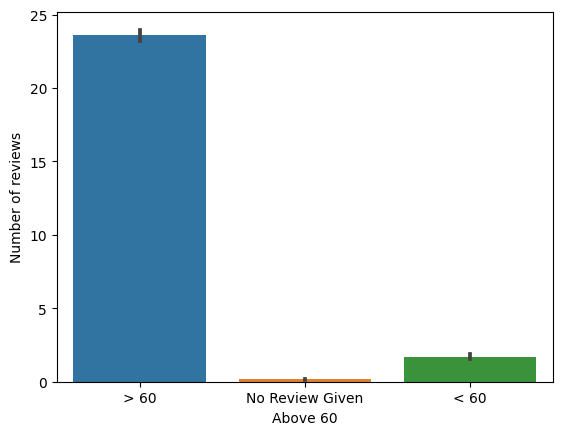

In [69]:
sns.barplot(dfOmit, x='Above 60', y='Number of reviews');

As can be seen clearly from the bar chart, properties with an average number of reviews below 3 are more likely to have a Review score less than 60.

In [70]:
pd.crosstab(dfOmit['Above 60'], dfOmit['Room type'], normalize = 'index')

Room type,Entire home/apt,Private room,Shared room
Above 60,,,
< 60,0.337500,0.600000,0.062500
> 60,0.518372,0.458044,0.023584
No Review Given,0.435512,0.533986,0.030502


Next from the cross tab chart we can see that properties that rent the Entire home are more likely to see Ratings above 60 and properties that rent out private or shared rooms are more likely to have Ratings below 60.

### Attributes That Contribute to Price

<AxesSubplot:xlabel='Bedrooms', ylabel='Price'>

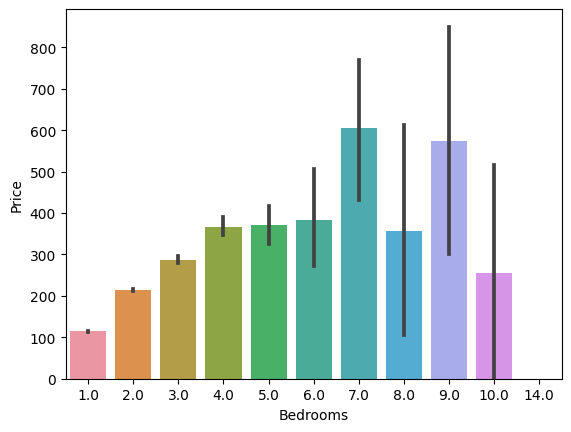

In [71]:
sns.barplot(dfOmit, x = 'Bedrooms', y='Price');

The bar plot shows that as the number of bedrooms increases so does price up to a point. Once 7 bedrooms is reached price begins to behave somewhat erradically.

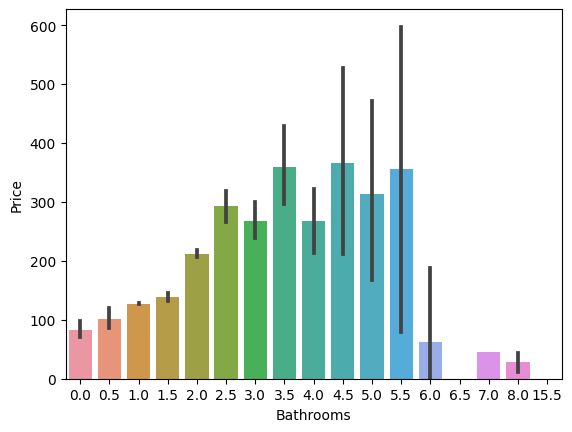

In [75]:
sns.barplot(dfOmit, x = 'Bathrooms', y='Price');

<b>Bedrooms</b> and <b>Bathrooms</b> are linearlly related as shown above by the PairGrid graph. This bar graph shows that <b>Bathrooms</b> may be a better predictor of price since it can be a bit more granular.

<AxesSubplot:xlabel='Room type', ylabel='Price'>

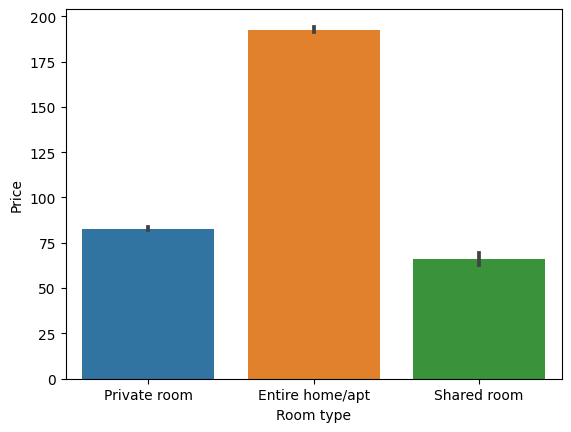

In [74]:
sns.barplot(dfOmit, x = 'Room type', y='Price');

Room type also plays a large role in the price of the listing. As can be seen above, hosts that provide the Entire home for rent see significantly higher prices than those that only list a private room or a share room.